# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Thresholding Correlations
Since we're only interested in high correlations between **sat_score** and other columns of our dataset, we'll narrow down our field of investigation. We're setting **-0.3** and **0.3** as the threshold values - meaning we'll only consider correlations that are lower or higher than these numbers respectively. 

In [12]:
def corr_filter(x):
    if (x < 0.3) & (x > -0.3):
        return np.nan
    else:
        return x

correlations_fltrd = correlations.apply(corr_filter)
correlations_fltrd.dropna(inplace=True)
correlations_fltrd
# correlations_fltrd = correlations.mask(correlations < 0.4)
# correlations_fltrd

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF LARGEST CLASS                   0.314434
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_percent                            -0.398750
sped_percent                           -0.448170
asian_num                               0.475445
asian_per                               0.570730
hispanic_per                           -0.396985
white_num                               0.449559
white_per           

In [13]:
len(correlations_fltrd)

30

We've narrowed our investigation to **16** correlations now. Let's plot a bar graph of these values to get a better sense of this data.

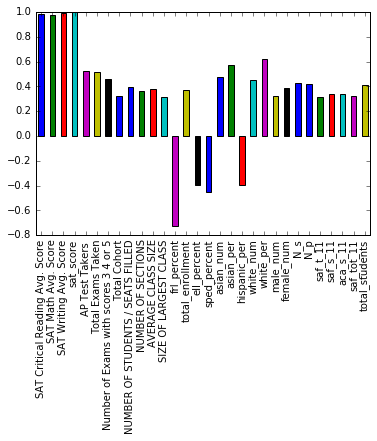

In [14]:
correlations_fltrd.plot(kind='bar')

From our analysis it appears that among other factors, average SAT score for any NY public schools is also positiely correlated with **sat_t_11** & **saf_s_11**, which is a peculiar insight. These values denote how safety at school is rated by teachers and students of that school respectively. 
Let's explore this phenomenon further. 

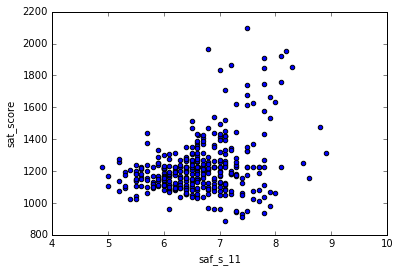

In [15]:
combined.plot(kind='scatter', x='saf_s_11', y='sat_score')

In [16]:
corr = combined['saf_s_11'].corr(combined['sat_score']).round(2)
corr

0.34

As evident from the plot, the **saf_s_11** and **sat_score** are somewhat loosely correlated (correlation coefficient = 0.34). 
It follows from this observation that the higher the perceived safety at a school, the more likely it is to have high average sat scores.

Let's investigate the safety scores further by splitting them according to NY boroughs and averaging them.

In [17]:
pd.set_option('max_columns', None)

In [18]:
combined.info

<bound method DataFrame.info of         DBN                                        SCHOOL NAME  \
0    01M292      HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES   
1    01M448                UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   
2    01M450                         EAST SIDE COMMUNITY SCHOOL   
3    01M509                            MARTA VALLE HIGH SCHOOL   
4    01M539  NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...   
5    01M696                     BARD HIGH SCHOOL EARLY COLLEGE   
6    02M047  47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECO...   
7    02M288                       FOOD AND FINANCE HIGH SCHOOL   
8    02M294                               ESSEX STREET ACADEMY   
9    02M296              HIGH SCHOOL OF HOSPITALITY MANAGEMENT   
10   02M298                                   PACE HIGH SCHOOL   
11   02M300  URBAN ASSEMBLY SCHOOL OF DESIGN AND CONSTRUCTI...   
12   02M303                         FACING HISTORY SCHOOL, THE   
13   02M305  URBAN ASSEMBLY ACADEMY OF GOVER

In [19]:
boro_safety = combined[['boro', 'saf_s_11', 'saf_t_11', 'sat_score']].groupby('boro').mean()
boro_safety

,saf_s_11,saf_t_11,sat_score
boro,,,
Bronx,6.606577,7.026882,1157.598203
Brooklyn,6.370755,6.985849,1181.364461
Manhattan,6.831370,7.287778,1278.331410
Queens,6.721875,7.365625,1286.753032
Staten Island,6.530000,7.210000,1382.500000


In [20]:
boro_safety['avg_safety'] = (boro_safety['saf_s_11'] + boro_safety['saf_t_11']) / 2
boro_safety.reset_index()

,boro,saf_s_11,saf_t_11,sat_score,avg_safety
0,Bronx,6.606577,7.026882,1157.598203,6.816729
1,Brooklyn,6.370755,6.985849,1181.364461,6.678302
2,Manhattan,6.831370,7.287778,1278.331410,7.059574
3,Queens,6.721875,7.365625,1286.753032,7.043750
4,Staten Island,6.530000,7.210000,1382.500000,6.870000


So the NY Boroughs having varying average safety scores. We can see that perceived safety is highest for schools in Manhattan, followed closely by Queens. They are followed by Staten Island, Bronx, and Brookyln in that order. 

Average SAT scores for schools in NY boroughs follow the same pattern - with Manhattan leading the way and followed by Queens, Staten Island, Bronx, and Brooklyn.

This shows there's discerable correlation between average sat scores and perceived safety scores for schools across different boroughs. 

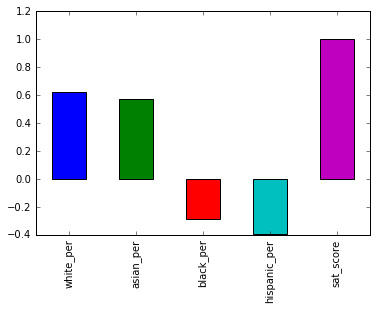

In [21]:
racial_corr = combined[['white_per', 'asian_per', 'black_per', 'hispanic_per', 'sat_score']].corr()
racial_corr['sat_score'].plot.bar(x=racial_corr.index, y='sat_score')

Plotting the correlations between percentage of white, asian, black, and hispanic students and sat scores across NY schools, we find that the percentage of white & asian students are positively correlated whereas those of black & hispanic students are negatively correlated with average sat scores of a school.

These findings are in line with studies showing that students of color, especially blacks & hispanics, face greater hurdles to education on account of their challenged socioeconomic circumstances. 

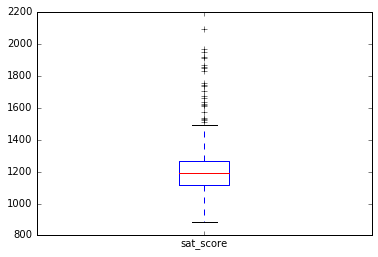

In [22]:
combined['sat_score'].plot.box()

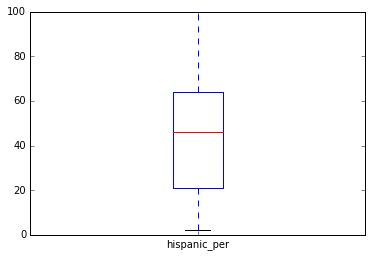

In [23]:
combined['hispanic_per'].plot.box()

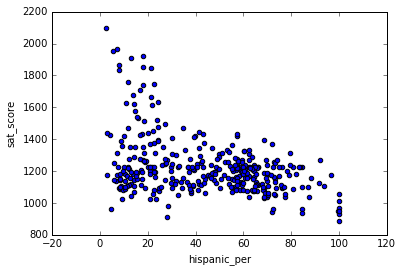

In [24]:
combined.plot.scatter(x='hispanic_per', y='sat_score')

From a plot of percentage of hispanic students in a school to its average sat score, we see that there appears to be a negative correlation between the two as hispanic percentage goes from 0 to about 30. After that however, the the strength of this relationship diminishes to the point that increases in hispanic fraction doesn't lead to any significant drop in average sat scores at a school.  

Let's delve deeper into the correlation between low sat scores and high percentage of hispanic students at a school.
Let's start by printing out the list of schools that have hispanic student ratio of >95%.

In [25]:
maj_hispanics = combined[combined['hispanic_per'] > 95]
maj_hispanics['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These schools belong to diferent NY boroughs & have varying student achievemnt levels, and accessibility. 

We'll now shift our attention to examining schools that have less than 10% hispanic students and and average sat score of greater than 1800.
Let's print out the names of such schools.

In [26]:
low_hisp_high_sat = combined[(combined['hispanic_per'] < 10) & (combined['sat_score']> 1800)]
low_hisp_high_sat['School Name']

37                    STUYVESANT HIGH SCHOOL
151             BRONX HIGH SCHOOL OF SCIENCE
187           BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES A
356      STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: School Name, dtype: object

From examining the schools with low (less than 10%) hispanic students and high average sat_scores (greater than 1800) we find that almost all of these schools are public mangnets. They're specialized STEM schools administered by NY City Department of Education that admit only selected pupils with high exceptional academic record. Entry to these schools is challenging as thousands of students compete for a limited number of seats.

It is thus easy to imagine that hispanics, being a minority, would find it harder than whites or asians to make it into these schools, espcially since many of the hispanic families are economically & socially disatvantaged.

In [27]:
pattern = r"school[\s_]*[[name]{4}]*"
for item in combined.columns:
    if re.match(pattern, item, re.IGNORECASE):
        print(item)

SCHOOL NAME
SchoolName
School Name
school_name


In [28]:
gender_sat_corr = combined[['male_per', 'female_per', 'sat_score']].corr()
gender_sat_corr

,male_per,female_per,sat_score
male_per,1.000000,-1.000000,-0.112062
female_per,-1.000000,1.000000,0.112108
sat_score,-0.112062,0.112108,1.000000


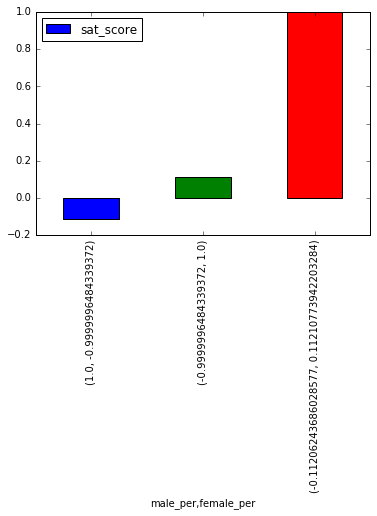

In [29]:
gender_sat_corr.plot.bar(x=['male_per','female_per'], y ='sat_score')

So percentage of male or female students at any school is slightly correlated with sat scores.
Whereas the percentage of boys is negatively correlated, propotion of female students at a school is positively correlated with average sat score of that school.
These correlations, however, are very weak (around 0.11).

In [30]:
combined['female_per'].value_counts(dropna=False).sort_index(ascending=False)

100.0    7
99.7     1
92.7     1
85.4     1
83.5     1
78.8     1
78.6     1
78.5     1
76.2     1
75.1     1
74.7     1
74.6     1
73.7     1
73.6     1
71.4     1
71.1     1
70.6     1
70.2     1
70.0     1
69.1     1
68.7     1
67.9     2
67.8     1
67.5     1
67.4     1
67.3     1
67.2     1
66.1     1
65.9     1
64.7     1
        ..
35.7     1
35.0     1
34.9     1
34.3     1
34.2     1
34.0     1
33.5     1
32.9     1
32.7     1
32.3     1
29.7     1
28.2     1
27.6     1
27.4     1
25.1     1
24.5     1
23.1     1
22.0     1
20.6     1
18.9     1
17.5     1
17.3     1
15.9     1
15.7     1
14.7     1
12.7     1
11.1     1
7.3      1
4.4      1
0.0      1
Name: female_per, Length: 228, dtype: int64

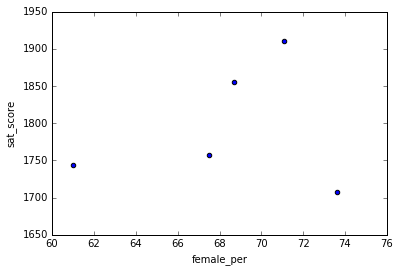

In [33]:
high_f_high_sat = combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]
high_f_high_sat.plot.scatter(x='female_per', y='sat_score')

So upon seperating schools with high female percentage (>50%) as well as high sat scores (>1800), we find that only 5 schools fit these conditions. The correlation between fraction of female students and sat scores among these schools is positive - as percentage of females increases, average sat score increases too.
The correlation score between the two is,

In [32]:
high_f_high_sat['female_per'].corr(high_f_high_sat['sat_score']).round(2)

0.18

This correlation however is small - indicating that the rise in percentage of of female students does not lead to propotional increase in average sat scores of a school.

Let's investigate these schools in more detail by printing their names.

In [34]:
high_f_high_sat['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

So upon a quick overview, we find that all of these schools are either college-preparatory or public magnet schools. This means they specialize in imparting STEM eductaion to highschool students and prepare them for the college studies ahead. <br>
Having high average SAT scores is expected from these colleges as they are very selective in their admissions and take in only a handful of students out of all the applicants that often number well into thousands. These students then go on to score higher than average SAT scores in their late high school years - resulting in a high average SAT scores for the school.

### Do AP Test Takers affect SAT?
Let's now try to investigate whether there's any link between the number of students taking AP exams and a school's average SAT score.
But AP test takers in any school could be highly correlated with total enrollment there - and we know for a fact that total enrollment is highly correlated with SAT scores.
So, let's first find out of there's any correlation between columns **AP Test Takers** and **total_enrollment**.

In [36]:
combined['AP Test Takers '].corr(combined['total_enrollment']).round(2)

0.65

**0.65** is a high correlation score. It indicates that in exploring the relationship between SAT scores and AP Test Takers, the latter could serve as a proxy for total enrollment, skewing our analysis. <br>
- So we need to design a new metric - one that accuratly captures any relationship between the probablity to take AP tests & a schools sat score. <br>

A better yardstick could be the percentage of students at a school who took atleast 1 AP test. If we explore relationship between this value and sat scores, we could move towards anwring the question of *whether higher number of AP test taken at a school translate to higher SAT scores?*


In [38]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']
combined['ap_per']

0      0.305756
1      0.098985
2      0.031773
3      0.351577
4      0.158091
5      0.209123
6      0.741545
7      0.297988
8      0.376177
9      0.307945
10     0.050725
11     0.229698
12     0.093126
13     0.080128
14     0.384014
15     0.341346
16     0.260664
17     0.297988
18     0.388641
19     0.424437
20     0.528807
21     0.152798
22     0.039841
23     0.180556
24     0.196891
25     0.295938
26     0.305720
27     0.137380
28     0.306482
29     0.115385
         ...   
333    0.029536
334    0.084567
335    0.877747
336    0.053398
337    0.268251
338    0.260664
339    0.307945
340    0.082513
341    0.119905
342    0.142857
343    0.055616
344    0.127682
345    0.143466
346    0.293247
347    0.242535
348    0.316247
349    0.123853
350    0.036117
351    0.090191
352    0.096787
353    0.102194
354    0.086031
355    0.191154
356    0.478261
357    0.356433
358    0.077558
359    0.297301
360    0.190955
361    0.026616
362    0.073593
Name: ap_per, Length: 36

The correlation score is 0.06.


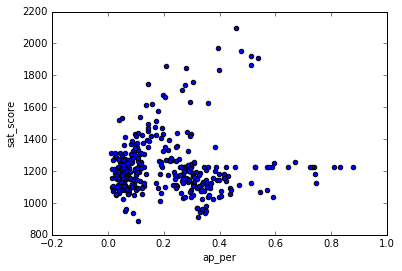

In [45]:
combined.plot(kind='scatter', x='ap_per', y='sat_score')
ap_sat_score = combined['ap_per'].corr(combined['sat_score']).round(2)
print("The correlation score is {0}.".format(ap_sat_score))

The plot between percentage of AP test takers at a school and it's average SAT score shows that a clear relationship between the two doen't exist. Increasing AP percentage can lead to higher as well as lower SAT scores.